**Name: Sharryl Seto (1005523)**

Class: Cl02

# Image classification from scratch

**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [2]:
import tensorflow as tf # Tensorflow is a neural network and deep neural network library
from tensorflow import keras # Keras is a high-level wrapper that makes working with tensorflow easier
from tensorflow.keras import layers # Layers contains different types of layers such as Dense, Convolutional, Recurrent

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  93.5M      0  0:00:08  0:00:08 --:--:-- 89.3M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.

In [5]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [6]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


## Generate a `Dataset`

In [48]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
and label 0 is "cat".

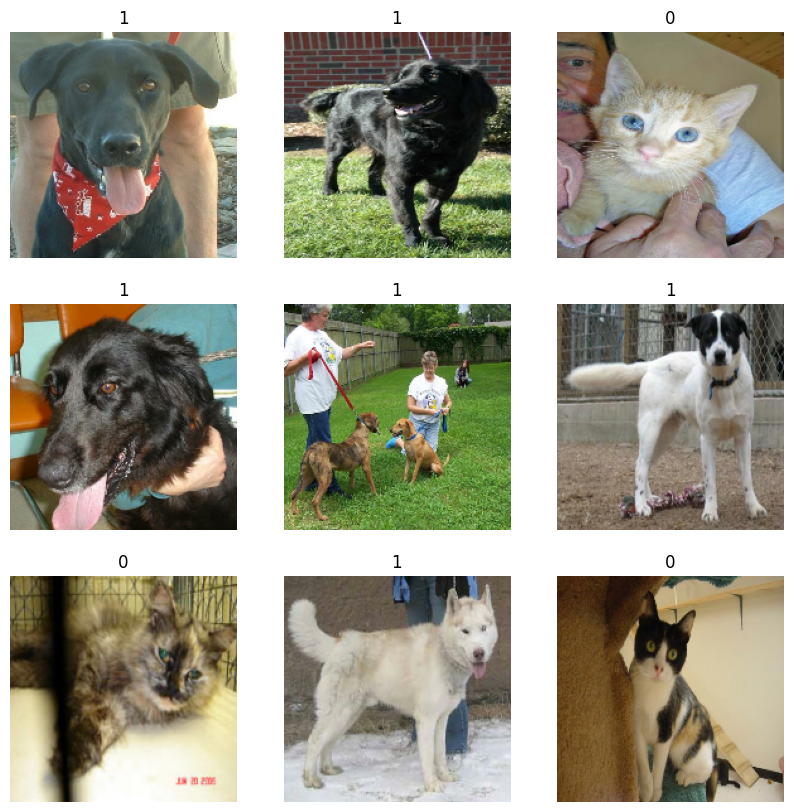

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [52]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
) # the concept of this sequential class is the same as sklearn pipeline that you learnt in week 5.
#Images are fed to this class and are flipped horizontally followed by a random rotation.

Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first image in the dataset:

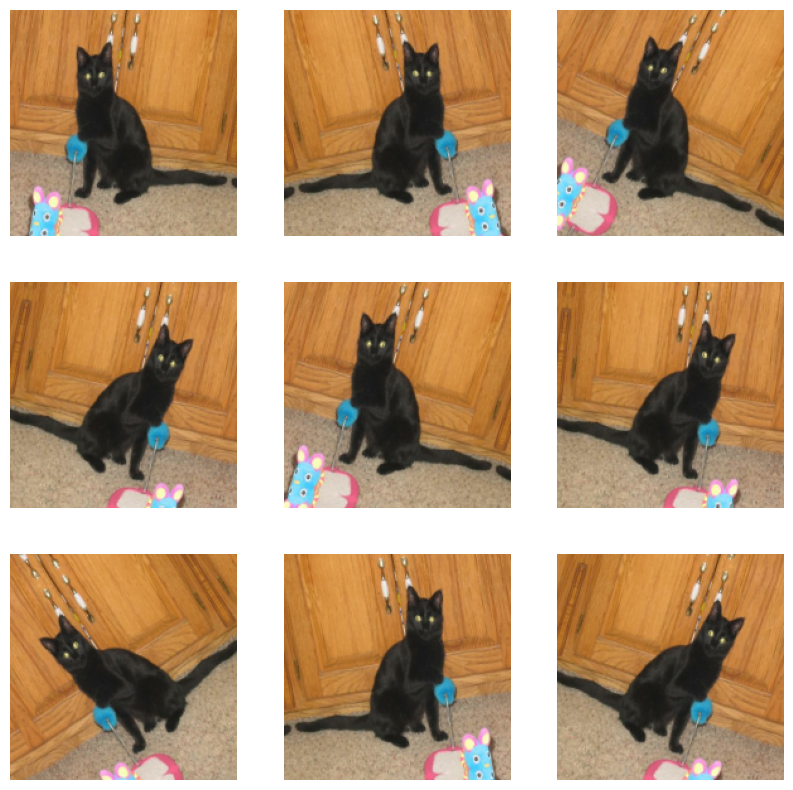

In [53]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [54]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.

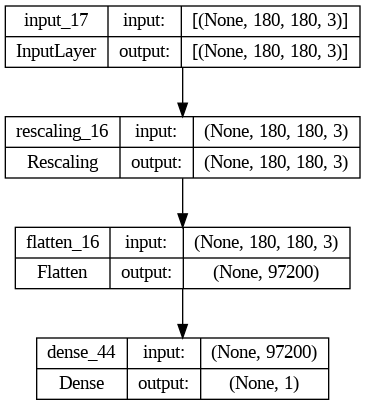

In [55]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Flatten()(x)
    # Write dense layers with non-linear activation here.
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes # num_class would be different for MNIST.


    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [56]:
epochs = 2

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=1, # You can change it
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy", # You would need to change here for MNIST; use categorical crossentropy
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/2
147/147 [==============================] - 90s 599ms/step - loss: 2.3945 - accuracy: 0.5178 - val_loss: 0.8404 - val_accuracy: 0.5340
Epoch 2/2
147/147 [==============================] - 89s 593ms/step - loss: 1.0644 - accuracy: 0.5315 - val_loss: 0.9545 - val_accuracy: 0.5305


The model converges when the loss on the validation dataset do not decrease for N number of epochs continously or the validation results do not improve for N successive N number of epochs. We can set N = 5,10 etc. This process is called early stopping and N is defined as patience.

## Run inference on new data

Note that data augmentation is inactive at inference time.

In [16]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0]) # You will get #units probability values here. To choose the final predicted output, need to call argmax. E.g., if the predictions are [0.2, 0.5, 0.3], your code should return the index 1 as the output as this index has the highest probability value i.e., 0.5
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 88ms/step
This image is 7.45% cat and 92.55% dog.


<ipython-input-16-41386ca2fc0d>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0]) # You will get #units probability values here. To choose the final predicted output, need to call argmax. E.g., if the predictions are [0.2, 0.5, 0.3], your code should return the index 1 as the output as this index has the highest probability value i.e., 0.5


#Questions:

## Q1 & 2

1. Create 2 hidden layers after calling x = layers.Flatten()(x). Sizes of these hidden layers are hyperparameter i.e., you have to determine the optimal value based on the performance of the model on the validation dataset.
2. Add non-linear activation in those Dense layers. Used ReLU and sigmoid.



In [ ]:
# ref: https://keras.io/examples/vision/image_classification_from_scratch/

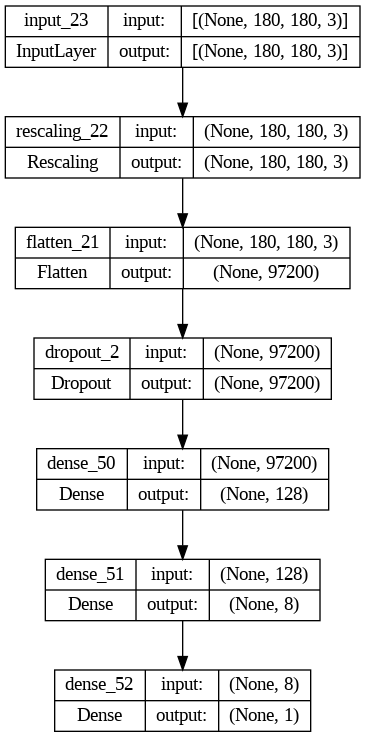

In [65]:
def make_model2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Flatten()(x)
    # added dropout
    x = layers.Dropout(0.2)(x)  # Regularize with dropout
    # Write dense layers with non-linear activation here.
    hidden1 = layers.Dense(128, activation='relu')(x)
    hidden2 = layers.Dense(8, activation='sigmoid')(hidden1)  #specify the number of hidden units

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes # num_class would be different for MNIST.

    outputs = layers.Dense(units, activation=activation)(hidden2)
    return keras.Model(inputs, outputs)


model = make_model2(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [66]:
epochs = 2
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=1, # You can change it
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)]
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy", # You would need to change here for MNIST; use categorical crossentropy
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/2
147/147 [==============================] - 91s 600ms/step - loss: 0.6859 - accuracy: 0.5472 - val_loss: 0.6728 - val_accuracy: 0.5925
Epoch 2/2
147/147 [==============================] - 98s 661ms/step - loss: 0.6738 - accuracy: 0.5803 - val_loss: 0.6596 - val_accuracy: 0.6179


Result was slightly better with 2 hidden layers with non-linear activation of relu and sigmoid respectively. Variations were tested and this seemed to be the best combination for a simple model with 2 hidden layers.

## Q3



3. Load the MNIST dataset using (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(). Re-write the above code so that it perfectly works on the MNIST dataset. Follow the steps below:

    a) Check the size of the MNIST dataset and standardize all the inputs so that they contain the same number of pixels.
  
    b) Split the training dataset into training and validation. You may use sklearn's train_test_split to do this. For more information: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

    c) Note that changing the code will require you to change the output activation from sigmoid and you will also need to change the loss function because MNIST is a multiclass classification problem.
    
    d) One workaround to step b is to use validation_split argument in model.fit() function. You may want to test this functionality.

In [102]:
# ref: https://keras.io/examples/vision/mnist_convnet/
import numpy as np

In [103]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [104]:
input_shape = (28, 28, 1)
num_classes = 10

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


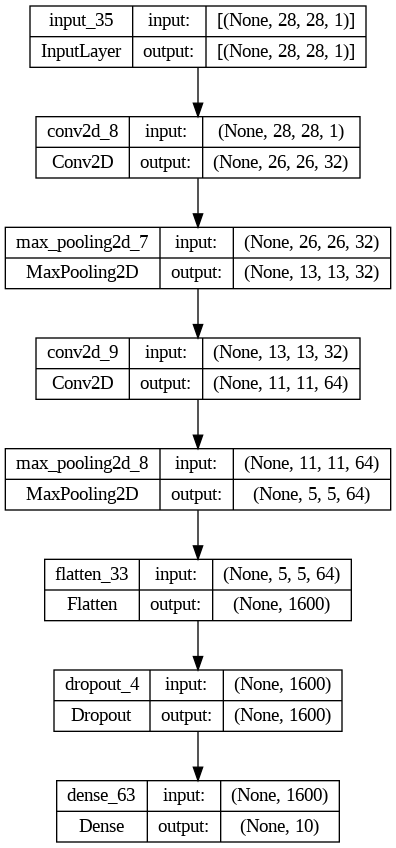

In [110]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

keras.utils.plot_model(model, show_shapes=True)

In [111]:
# # train test split
# from sklearn.model_selection import train_test_split

# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

In [112]:
batch_size = 128
epochs = 15

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy", # You would need to change here for MNIST; use categorical crossentropy
    metrics=["accuracy"],
)

# train validation split done here
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/15
375/375 [==============================] - 5s 7ms/step - loss: 2.2553 - accuracy: 0.1863 - val_loss: 2.1913 - val_accuracy: 0.5158
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 2.1307 - accuracy: 0.3716 - val_loss: 2.0226 - val_accuracy: 0.7111
Epoch 3/15
375/375 [==============================] - 2s 4ms/step - loss: 1.9262 - accuracy: 0.5295 - val_loss: 1.7424 - val_accuracy: 0.7828
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 1.6340 - accuracy: 0.6123 - val_loss: 1.3893 - val_accuracy: 0.8052
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 1.3364 - accuracy: 0.6629 - val_loss: 1.0765 - val_accuracy: 0.8245
Epoch 6/15
375/375 [==============================] - 2s 4ms/step - loss: 1.1018 - accuracy: 0.7030 - val_loss: 0.8558 - val_accuracy: 0.8397
Epoch 7/15
375/375 [==============================] - 2s 6ms/step - loss: 0.9472 - accuracy: 0.7264 - val_loss: 0.7106 - val_accuracy: 0.8528
Epoch 

In [113]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.352934330701828
Test accuracy: 0.911300003528595
